In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [4]:
from typing import Tuple
from time import time
import random

from PIL import Image, ImageDraw
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
import skimage.morphology as morp
import cv2

from deep_morpho.models.bimonn_axspa import BimonnAxspaPipeline, BimonnAxspaFromSegm
from general.utils import set_borders_to

from deep_morpho.datasets.utils import (
    rand_shape_2d,
    invert_proba,
    get_rect_vertices,
    draw_poly,
    draw_ellipse
)


# Model

In [100]:
# model = BimonnAxspaPipeline()
model = BimonnAxspaFromSegm()

img = torch.rand(1, 2, 256, 256)
otp = model(img)

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


# SpaLike Dataset

In [54]:
def get_random_rotated_diskorect(
    size: Tuple, n_shapes: int = 30, max_shape: Tuple[int] = (15, 15), p_invert: float = 0.5,
        border=(0, 0), n_holes: int = 15, max_shape_holes: Tuple[int] = (5, 5), noise_proba=0.05,
        rng_float=np.random.rand, rng_int=np.random.randint, **kwargs
):
    diskorect = np.zeros(size)
    img = Image.fromarray(diskorect)
    draw = ImageDraw.Draw(img)

    def draw_shape(max_shape, fill_value):
        x = rng_int(0, size[0] - 2)
        y = rng_int(0, size[0] - 2)

        if rng_float() < .5:
            W = rng_int(1, max_shape[0])
            L = rng_int(1, max_shape[1])

            angle = rng_float() * 45
            draw_poly(draw, get_rect_vertices(x, y, W, L, angle), fill_value=fill_value)

        else:
            rx = rng_int(1, max_shape[0]//2)
            ry = rng_int(1, max_shape[1]//2)
            draw_ellipse(draw, np.array([x, y]), (rx, ry), fill_value=fill_value)

    for _ in range(n_shapes):
        draw_shape(max_shape=max_shape, fill_value=1)

    for _ in range(n_holes):
        draw_shape(max_shape=max_shape_holes, fill_value=0)

    diskorect = np.asarray(img) + 0
    diskorect[rand_shape_2d(diskorect.shape, rng_float=rng_float) < noise_proba] = 1  # bernoulli noise
    diskorect = invert_proba(diskorect, p_invert, rng_float=rng_float)  # random invert

    diskorect = set_borders_to(diskorect, border, value=0)

    return diskorect

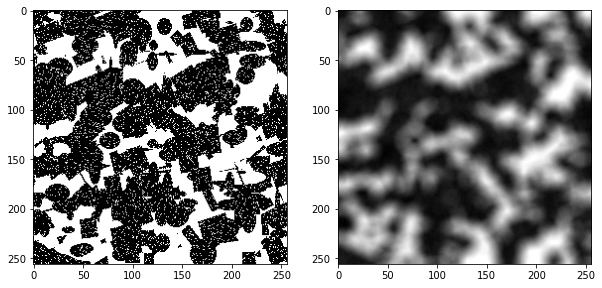

In [94]:
img = get_random_rotated_diskorect(
    (256, 256), 
    n_shapes=300, 
    max_shape=(60, 40), 
    max_shape_holes=(30, 30), 
    n_holes=300, 
    noise_proba=0.1, 
    p_invert=0, 
)
fimg = convolve(img, morp.disk(9))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, cmap="gray")

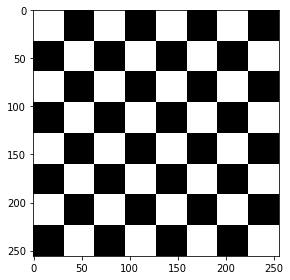

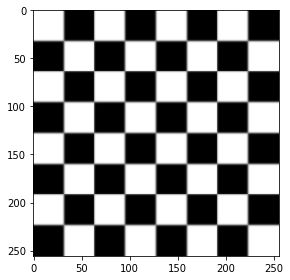

In [2]:
from skimage import data, io, color
import numpy as np


texture = np.kron([[1, 0] * 4, [0, 1] * 4] * 4, np.ones((32, 32)))
io.imshow(texture, cmap='gray')
io.show()
from skimage.filters import gaussian

# Apply Gaussian blur to the texture
blurred_texture = gaussian(texture, sigma=1)

io.imshow(blurred_texture, cmap='gray')
io.show()


In [5]:
image_size = (128, 128)  # Adjust the size as needed
triangle_size = (32, 32)  # Size of the triangle representing the joint
num_samples = 100  # Number of samples

def generate_synthetic_image():
    # Create a blank image with a textured background
    background = np.random.randint(0, 256, size=(image_size[0], image_size[1], 3), dtype=np.uint8)

    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], triangle_color)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    return background, classification_info


In [12]:
def generate_synthetic_image():
    # Create a blank image with a homogeneous patterned texture
    background = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # Create a pattern or texture (e.g., checkerboard)
    pattern_color1 = (192, 192, 192)  # Gray
    pattern_color2 = (128, 128, 128)  # Dark gray
    square_size = 16  # Size of each square in the pattern

    for i in range(0, image_size[0], square_size):
        for j in range(0, image_size[1], square_size):
            if (i // square_size + j // square_size) % 2 == 0:
                background[i:i+square_size, j:j+square_size] = pattern_color1
            else:
                background[i:i+square_size, j:j+square_size] = pattern_color2

    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], triangle_color)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    return background, classification_info


In [17]:

num_samples = 100  # Number of samples
square_size = 16  # Size of each square in the pattern
num_colors = 3  # Number of random colors for squares
def generate_synthetic_image():
    # Create a blank image with a random patterned texture
    background = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], triangle_color)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    # Randomly color the squares in the background
    for i in range(0, image_size[0], square_size):
        for j in range(0, image_size[1], square_size):
            square_color = [random.randint(0, 255) for _ in range(num_colors)]
            background[i:i+square_size, j:j+square_size] = square_color

    return background, classification_info

In [28]:
image_size = (128, 128)  # Adjust the size as needed
triangle_size = (32, 32)  # Size of the triangle representing the joint
num_samples = 100  # Number of samples
num_squares = 100  # Number of random squares
min_square_size = 8  # Minimum square size
max_square_size = 32  # Maximum square size
num_colors = 3  # Number of random colors for squares

def generate_synthetic_image():
    # Create a blank image with a random patterned texture
    background = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
    
    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    # Randomly generate squares with different sizes and colors
    for _ in range(num_squares):
        square_size = random.randint(min_square_size, max_square_size)
        x = random.randint(0, image_size[0] - square_size)
        y = random.randint(0, image_size[1] - square_size)
        square_color = random.randint(0, 255)
        background[y:y+square_size, x:x+square_size] = square_color

    cv2.fillPoly(background, [triangle], triangle_color)
    return background, classification_info

In [99]:
def f(x, period):
    return (np.sin(x * 2 * np.pi / period) + )  

print(f(1, 1))
print(f(2, 1))

-2.4492935982947064e-16
-4.898587196589413e-16


In [457]:
from abc import ABC, abstractmethod

class Texture(ABC):
    @abstractmethod
    def draw(self, img):
        pass


class GridEllipse(Texture):

    def __init__(
        self,
        grid_spacing: tuple,
        min_ellipse_axes: int,
        max_ellipse_axes: int,
        period: tuple,
        offset: tuple = (0, 0),
        min_output_ellipse: int = 127,
    ):
        self.grid_spacing = self.tuplify(grid_spacing)

        self.min_ellipse_axes = min_ellipse_axes
        self.max_ellipse_axes = max_ellipse_axes
        
        self.period = self.tuplify(period)
        self.offset = self.tuplify(offset)

        self.sin_grid_min = 3
        self.min_output_ellipse = min_output_ellipse

    @property
    def sin_grid_max(self):
        return self.sin_grid_min + 4

    @staticmethod
    def tuplify(x):
        if isinstance(x, int):
            return (x, x)
        else:
            return x

    def draw(self, img: np.ndarray) -> np.ndarray:
        # Randomly generate ellipses with different shapes and colors in a grid
        img = img + 0
        Xs = np.linspace(0, image_size[0], num=int(image_size[0] / self.grid_spacing[0]) + 1, dtype=np.int32)
        Ys = np.linspace(0, image_size[1], num=int(image_size[1] / self.grid_spacing[1]) + 1, dtype=np.int32)
        
        for idx_x, center_x in enumerate(Xs):
            for idx_y, center_y in enumerate(Ys):
                ellipse_axes = (random.randint(self.min_ellipse_axes, self.max_ellipse_axes), random.randint(self.min_ellipse_axes, self.max_ellipse_axes))
                angle = random.uniform(0, 360)  # Random rotation angle
                ellipse_color = self.normalize(self.sin_grid(idx_x + 1, idx_y + 1, ))
                # Draw the random ellipse
                cv2.ellipse(img, (center_x, center_y), ellipse_axes, angle, 0, 360, ellipse_color, -1)

        return img

    # sinusoidal grid
    def sin_grid(self, x: float, y: float, ):
        return (
            (self.sin_period(x - self.offset[0], self.period[0]) + 1) * (self.sin_period(y - self.offset[1], self.period[1]) + 1)
        ) + self.sin_grid_min

    def normalize(self, x, ):
        return (x - self.sin_grid_min) / (self.sin_grid_max - self.sin_grid_min) * (255 - self.min_output_ellipse) + self.min_output_ellipse

    @staticmethod
    def sin_period(x, period):
        return (np.sin(x * 2 * np.pi / period) + 1) / 2



class BonesLike:
    
    def __init__(
        self,
    ):
        self.img = None

        self.iliac_segmentation = None
        self.sacrum_segmentation = None
        
        self.iliac_coordinates = None
        self.sacrum_coordinates = None

    def draw_bones(self, img):
        img = img + 0
        W, L = img.shape
        size_sacrum = (int(.3 * W), int(.3 * L))
        w, l = size_sacrum
        

        self.sacrum_segmentation = np.zeros(img.shape).astype(bool)
        self.sacrum_segmentation[
            W//2 - w//2:W//2 + w//2, 
            -l:
        ] = True

        self.sacrum_coordinates = [
            np.array([(W - w) // 2, L - l]), np.array([(W + w) // 2, L - 1])
        ]

        sacrum_value = np.random.randint(160, 240)
        img[self.sacrum_segmentation] = sacrum_value

        p1 = [
            np.random.randint((W - w) / 2 - .5*w, (W - w) / 2 - .1*w),
            L - l
        ]
        p2 = [
            np.random.randint((W - w) / 2 + w, (W - w) / 2 + 1.1*w),
            L - l
        ]
        p3 = [
            np.random.randint(p1[0], self.sacrum_coordinates[0][0]),
            np.random.randint(p1[1] - .5 * w, p1[1] - .3*w)
        ]

        triangle1 = np.array([
            p1[::-1], p2[::-1], p3[::-1]
        ], np.int32)

        p4 = [
            np.random.randint(.6 * p1[0], .9 * p1[0]),
            np.random.randint(p3[1] - .7 * (p2[0] - p1[0]), p3[1] - .3 * (p2[0] - p1[0]))
        ]
        triangle2 = np.array([
            p1[::-1], p4[::-1], p3[::-1]
        ], np.int32)


        self.iliac_segmentation = np.zeros_like(img)
        cv2.fillPoly(self.iliac_segmentation, [triangle1, triangle2], 1)
        self.iliac_segmentation = self.iliac_segmentation.astype(bool)
        
        iliac_value = np.random.randint(160, 240)
        img[self.iliac_segmentation] = iliac_value
        
        self.iliac_coordinates = [p1, p2, p3, p4]

        return img

    @property
    def segmentation(self):
        return np.concatenate([(self.iliac_segmentation == 1), self.sacrum_segmentation], axis=1)

    def draw_lesion(self, img):
        pass

    def draw(self, img):
        img = self.draw_bones(img)
        # img = self.draw_lesion(img)
        return img
        


class SpaLike:

    def __init__(
        self,
        image_size,
        bone_generator: BonesLike,
        texture_generator: Texture,
    ):
        self.image_size = image_size
        self.bone_generator = bone_generator
        self.texture_generator = texture_generator
    

    def generate_image(self):
        img = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
        img = self.texture_generator.draw(img)
        img = self.bone_generator.draw(img)
        fimg = convolve(img, np.ones((3, 3)))

        return img, fimg, segm
        



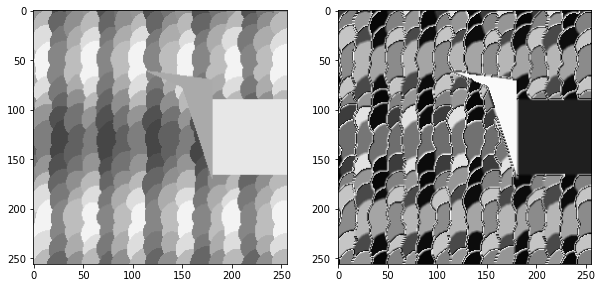

In [497]:
img = np.zeros((256, 256), dtype=np.uint8)

texture = GridEllipse(
    grid_spacing=(16, 16),
    min_ellipse_axes=13,
    max_ellipse_axes=18,
    period=(3, 10),
    offset=(1, 2),
    min_output_ellipse=0,
)

bone_gen = BonesLike()

gen = SpaLike((256, 256), bone_gen, texture)
fimg, img = gen.generate_image()
# img = texture.draw(img)
# img = bone_gen.draw_bones(img)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, vmin=0, vmax=255, cmap="gray")


In [265]:
import cv2
import numpy as np
import random

# Set parameters for your toy dataset
image_size = (256, 256)  # Adjust the size as needed
triangle_size = (32, 32)  # Size of the triangle representing the joint
num_samples = 100  # Number of samples
grid_spacing = 16  # Spacing between ellipses
num_ellipses = 100  # Number of random ellipses
min_ellipse_axes = 13  # Minimum size of ellipse axes
max_ellipse_axes = 18  # Maximum size of ellipse axes
num_colors = 3  # Number of random colors for ellipses


# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1]) + 3


def normalize(x, minv, maxv, min_output_value=0):
    # print(maxv, minv)
    return (x - minv) / (maxv - minv) * (255 - min_output_value) + min_output_value

def generate_synthetic_image(period, offset=(1, 2)):
    # Create a blank image with a grid of ellipses as texture
    background = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
    
    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    # Randomly generate ellipses with different shapes and colors in a grid
    Xs = np.linspace(0, image_size[0], num=int(image_size[0] / grid_spacing) + 1, dtype=np.int32)
    Ys = np.linspace(0, image_size[1], num=int(image_size[1] / grid_spacing) + 1, dtype=np.int32)
    
    # values = sin_grid(np.array(image_size) + 1)

    for idx_x, center_x in enumerate(Xs):
        for idx_y, center_y in enumerate(Ys):
            ellipse_axes = (random.randint(min_ellipse_axes, max_ellipse_axes), random.randint(min_ellipse_axes, max_ellipse_axes))
            angle = random.uniform(0, 360)  # Random rotation angle
            # ellipse_color = random.randint(0, 255)
            ellipse_color = normalize(sin_grid(idx_x + 1, idx_y + 1, period=period, offset=offset), minv=3, maxv=7)
            
            # Draw the random ellipse
            cv2.ellipse(background, (center_x, center_y), ellipse_axes, angle, 0, 360, ellipse_color, -1)

    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], random.randint(64, 170))
    return background, classification_info

4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.536707612778635
4.536707612778635
4.809161060780645
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
5.331420873505193
5.899519052838329
6.467617232171466
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
5.331420873505193
4.980316889730381
4.980316889730381
5.331420873505192
5.899519052838329
6.467617232171465
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
4.286901248056099
4.600480947161671
4.914060646267244
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.286901248056099
4.093098335826889
4.093098335826889
4.286901248056098
4.600480947161671
4.914060646267243
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.53670761277863

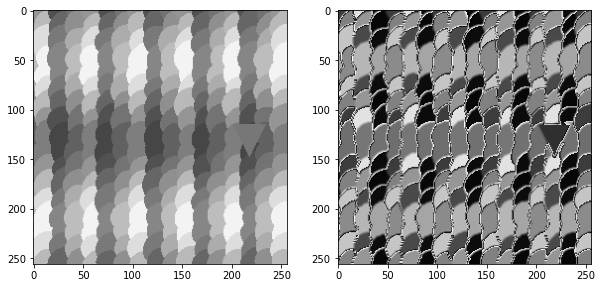

In [266]:
img, label = generate_synthetic_image(period=(3, 10))
# img += np.random.randint(0, 10, img.shape, dtype=np.uint8)
# img, label = generate_synthetic_image(period=(10, 3))
# convolve the img
fimg = convolve(img, np.ones((3, 3)))
# fimg = convolve(img, morp.disk(3))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, vmin=0, vmax=255, cmap="gray")

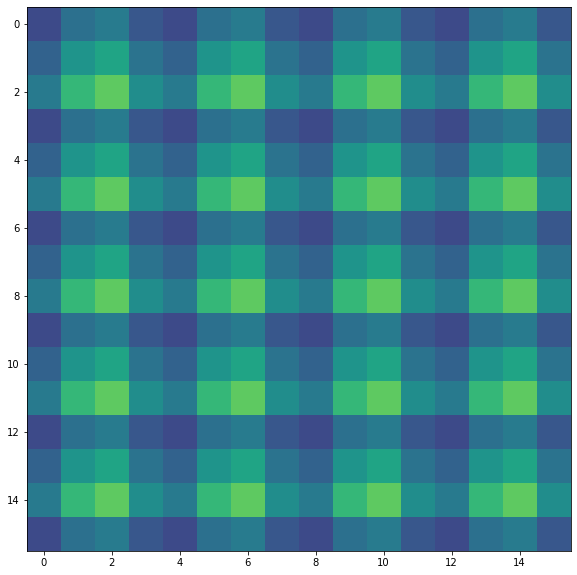

In [166]:
# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1])

XX, YY = np.meshgrid(np.arange(16), np.arange(16))
ZZ = sin_grid(XX, YY, period=(4, 3), offset=[.7, 1])

plt.figure(figsize=(10, 10))
plt.imshow(ZZ, vmin=0, vmax=5,)


In [231]:
%%timeit 
img, label = generate_synthetic_image()


2.96 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
